In [13]:
# %%
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Project directories (run notebook from repo root)
ROOT = Path.cwd()
DATA_DIR = ROOT / "data"
NOTEBOOKS_DIR = ROOT / "notebooks"
OUTPUT_DIR = ROOT / "output"
MODELS_DIR = OUTPUT_DIR / "models"

for d in (DATA_DIR, NOTEBOOKS_DIR, OUTPUT_DIR, MODELS_DIR):
    d.mkdir(parents=True, exist_ok=True)

# Helper to convert Path to string when needed
def p(pathobj):
    return str(pathobj)

print("ROOT:", ROOT)
print("DATA_DIR:", DATA_DIR)


ROOT: /home/nuevacomp/PetroNativeAI/Use Cases/Petrophysics/Published on Github
DATA_DIR: /home/nuevacomp/PetroNativeAI/Use Cases/Petrophysics/Published on Github/data


In [14]:
def load_intervals(reference_csv):
    """
    Load hydrocarbon and water depth intervals from a reference CSV file.
    Parameters:
    - reference_csv (str or Path): Path to the reference CSV file containing depth intervals.
    Returns:
    - hydrocarbon_intervals (dict): mapping well names -> list of (top, bottom) tuples
    - water_intervals (dict): mapping well names -> list of (top, bottom) tuples
    """
    df_intervals = pd.read_csv(p(reference_csv)) if not isinstance(reference_csv, pd.DataFrame) else reference_csv.copy()
    
    hydrocarbon_intervals = {}
    water_intervals = {}
    
    hydrocarbon_markers = ['GUT', 'GDT', 'GOC', 'OUT', 'ODT']
    water_markers = ['OWC', 'WUT', 'WDT']
    
    for col in range(1, df_intervals.shape[1]):  # Skip first column (markers)
        well_name = df_intervals.iloc[0, col]
        if pd.isna(well_name):
            continue
        well_name = str(well_name)
        hydrocarbon_intervals.setdefault(well_name, [])
        water_intervals.setdefault(well_name, [])
        
        for row in range(1, df_intervals.shape[0]):  # Skip header row
            marker = df_intervals.iloc[row, 0]
            depth = df_intervals.iloc[row, col]
            if pd.notna(depth):
                if marker in hydrocarbon_markers:
                    hydrocarbon_intervals[well_name].append((depth, depth))
                elif marker in water_markers:
                    water_intervals[well_name].append((depth, depth))
    
    return hydrocarbon_intervals, water_intervals


def is_within_intervals(depth, intervals):
    """Check if the given depth is within any of the specified intervals."""
    try:
        depth = float(depth)
    except Exception:
        return False

    for top, bottom in intervals:
        try:
            if float(top) <= depth <= float(bottom):
                return True
        except Exception:
            continue
    return False


def determine_fluid_type(depth, hydrocarbon_intervals, water_intervals):
    """Determine the fluid type for a given depth."""
    if is_within_intervals(depth, hydrocarbon_intervals):
        return 'Hydrocarbon'
    elif is_within_intervals(depth, water_intervals):
        return 'Water'
    else:
        return 'Non-fluid'


def predict_RT_random_forest(data_directory, reference_csv, random_state=42, n_estimators=300):
    """
    Read CSVs from data_directory, train a RandomForestRegressor on all wells except AK-9,
    predict RT for AK-9, and plot results.

    Parameters:
    - data_directory (str or Path): directory where well CSVs are stored (recommended: DATA_DIR)
    - reference_csv (str or Path): path to reference intervals CSV (recommended: DATA_DIR / "reference_intervals.csv")
    - random_state (int): reproducibility seed
    - n_estimators (int): number of trees in the Random Forest

    Returns:
    - rf_model, ak9_pred_df, mse
    """
    data_dir = Path(data_directory)
    ref_csv = reference_csv

    hydrocarbon_intervals, water_intervals = load_intervals(ref_csv)
    print("Hydrocarbon Intervals:", hydrocarbon_intervals)
    print("Water Intervals:", water_intervals)

    wells_data = {}
    for filename in sorted(os.listdir(p(data_dir))):
        if filename.lower().endswith('.csv'):
            well_name = os.path.splitext(filename)[0]
            file_path = data_dir / filename
            try:
                df = pd.read_csv(p(file_path))
                df['Well'] = well_name
                wells_data[well_name] = df
            except Exception as e:
                print(f"Error reading file {filename}: {e}")

    if "AK-9" not in wells_data:
        raise ValueError("AK-9 CSV file not found in the directory.")

    train_X_list = []
    train_y_list = []

    for well, df in wells_data.items():
        if well == "AK-9":
            continue
        if not set(['DEPT', 'GR', 'RT']).issubset(df.columns):
            print(f"Warning: Well {well} does not contain the required columns. Skipping.")
            continue

        df['Fluid_Type'] = df['DEPT'].apply(lambda x: determine_fluid_type(x,
                                                                         hydrocarbon_intervals.get(well, []),
                                                                         water_intervals.get(well, [])))
        df['In_Hydrocarbon_Interval'] = df['Fluid_Type'].apply(lambda x: 1 if x == 'Hydrocarbon' else 0)
        df['In_Water_Interval'] = df['Fluid_Type'].apply(lambda x: 1 if x == 'Water' else 0)

        df_clean = df[['DEPT', 'GR', 'RT', 'In_Hydrocarbon_Interval', 'In_Water_Interval']].dropna()
        train_X_list.append(df_clean[['DEPT', 'GR', 'In_Hydrocarbon_Interval', 'In_Water_Interval']])
        train_y_list.append(df_clean['RT'])

    if len(train_X_list) == 0:
        raise ValueError("No training data available. Check your CSV files and column names.")

    X_train = pd.concat(train_X_list, ignore_index=True)
    y_train = pd.concat(train_y_list, ignore_index=True)
    print("Training data shape:", X_train.shape)

    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf_model.fit(X_train, y_train)

    y_train_pred = rf_model.predict(X_train)
    mse = mean_squared_error(y_train, y_train_pred)
    print("Training MSE: {:.4f}".format(mse))

    ak9_df = wells_data["AK-9"]
    if not set(['DEPT', 'GR']).issubset(ak9_df.columns):
        raise ValueError("AK-9 CSV file must have at least DEPT and GR columns.")

    ak9_df['Fluid_Type'] = ak9_df['DEPT'].apply(lambda x: determine_fluid_type(x,
                                                                               hydrocarbon_intervals.get("AK-9", []),
                                                                               water_intervals.get("AK-9", [])))
    ak9_df['In_Hydrocarbon_Interval'] = ak9_df['Fluid_Type'].apply(lambda x: 1 if x == 'Hydrocarbon' else 0)
    ak9_df['In_Water_Interval'] = ak9_df['Fluid_Type'].apply(lambda x: 1 if x == 'Water' else 0)

    ak9_test = ak9_df[['DEPT', 'GR', 'In_Hydrocarbon_Interval', 'In_Water_Interval']].dropna().reset_index(drop=True)
    ak9_pred = rf_model.predict(ak9_test)

    ak9_pred_df = ak9_test.copy()
    ak9_pred_df['Predicted_RT'] = ak9_pred

    plt.figure(figsize=(6, 8))
    plt.plot(ak9_pred_df['Predicted_RT'], ak9_pred_df['DEPT'], label='Predicted RT', color='b')
    plt.gca().invert_yaxis()
    plt.xlabel("Resistivity (RT)")
    plt.ylabel("Depth (DEPT)")
    plt.title("Predicted RT Curve for AK-9")
    plt.legend()
    plt.grid(True)
    plt.xscale('log')
    plt.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)
    plt.grid(which='major', color='black', linestyle='-', linewidth=0.75)
    plt.minorticks_on()
    plt.xlim(0, 2000)
    plt.show()

    return rf_model, ak9_pred_df, mse


# Example usage (recommended to use DATA_DIR and DATA_DIR / "reference_intervals.csv"):
# rf_model, ak9_pred_df, mse = predict_RT_random_forest(DATA_DIR, DATA_DIR / "reference_intervals.csv")


Hydrocarbon Intervals: {'4838.0': [(5031.0, 5031.0), (5088.0, 5088.0), (5184.0, 5184.0)], '5114.0': [(5168.0, 5168.0), (5198.0, 5198.0)], '5014.0': [(5105.0, 5105.0), (5141.0, 5141.0), (5166.0, 5166.0), (5258.0, 5258.0)], '5063.0': [(5168.0, 5168.0)], '5136.0': [(5156.0, 5156.0), (5188.0, 5188.0), (5320.0, 5320.0)], '5081.0': [(5165.0, 5165.0)], '5088.0': [(5165.0, 5165.0)], '5017.0': [(5183.0, 5183.0)]}
Water Intervals: {'4838.0': [(5121.0, 5121.0), (5142.0, 5142.0), (5274.0, 5274.0), (5317.0, 5317.0)], '5114.0': [(5201.0, 5201.0), (5204.0, 5204.0), (5312.0, 5312.0), (5348.0, 5348.0), (5419.0, 5419.0), (5463.0, 5463.0), (5605.0, 5605.0)], '5014.0': [(5199.0, 5199.0), (5216.0, 5216.0), (5352.0, 5352.0), (5386.0, 5386.0)], '5063.0': [(5201.0, 5201.0), (5262.0, 5262.0), (5297.0, 5297.0), (5385.0, 5385.0), (5426.0, 5426.0), (5589.0, 5589.0)], '5136.0': [(5189.0, 5189.0), (5218.0, 5218.0), (5296.0, 5296.0), (5344.0, 5344.0), (5438.0, 5438.0)], '5081.0': [(5198.0, 5198.0), (5255.0, 5255.0)]

/tmp/ipykernel_22058/819343367.py:162: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 2000)


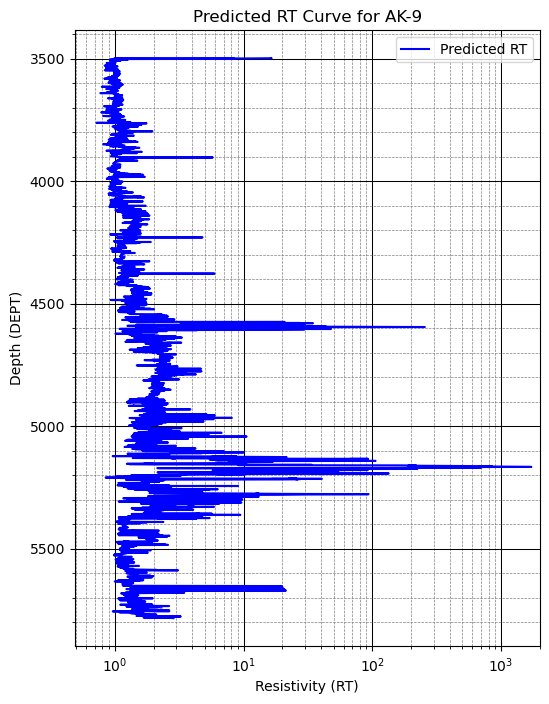

First few predictions for Well AK-9:
         DEPT       GR  In_Hydrocarbon_Interval  In_Water_Interval  \
0  3497.42200  61.8172                        0                  0   
1  3497.84535  61.7498                        0                  0   
2  3498.26870  63.5458                        0                  0   
3  3498.69205  65.9944                        0                  0   
4  3499.11540  68.4277                        0                  0   
5  3499.53875  70.0881                        0                  0   
6  3499.96210  71.1977                        0                  0   
7  3500.38545  72.1716                        0                  0   
8  3500.80880  74.0863                        0                  0   
9  3501.23215  76.6759                        0                  0   

   Predicted_RT  
0     16.424324  
1     16.502677  
2     13.265131  
3     10.544071  
4      0.985552  
5      1.606997  
6      2.725385  
7      8.547439  
8      1.422333  
9      0.995

In [15]:
# %%
# Set the path to the directory that contains the CSV files with the well data.
# Adjust this path to point to the correct directory on your machine.
data_directory = ROOT  # use repo-relative data directory
reference_csv = ROOT / "AK_contacts.csv"  # reference intervals file inside data/

# Run our function to train the model and make predictions for well "AK-9"
model, ak9_predictions, training_mse = predict_RT_random_forest(data_directory, reference_csv, random_state=42, n_estimators=300)

# Print the first few rows of the predictions DataFrame to check the results.
print("First few predictions for Well AK-9:")
print(ak9_predictions.head(10))



In [16]:
# %%
# This cell is optional but helps you visualize the distribution of the training data.
# We will reconstruct X_train from the previously processed CSV files.

# Create lists to hold the training features.
train_X_list = []
for filename in os.listdir(p(DATA_DIR)):
    if filename.lower().endswith('.csv'):
        well_name = os.path.splitext(filename)[0]
        # Skip AK-9 for training features.
        if well_name == "AK-9":
            continue
        file_path = DATA_DIR / filename
        try:
            df = pd.read_csv(p(file_path))
            # Ensure the required columns exist.
            if set(['DEPT', 'GR', 'RT']).issubset(df.columns):
                df_clean = df[['DEPT', 'GR']].dropna()
                train_X_list.append(df_clean)
        except Exception as e:
            print(f"Error reading file {filename}: {e}")
            
# If any training data was loaded, concatenate and plot
if train_X_list:
    X_train_full = pd.concat(train_X_list, ignore_index=True)
    
    # Plot histogram for DEPT
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(X_train_full['DEPT'], bins=30, color='skyblue', edgecolor='black')
    plt.xlabel("DEPT")
    plt.ylabel("Frequency")
    plt.title("Distribution of DEPT in Training Data")
    
    # Plot histogram for GR
    plt.subplot(1, 2, 2)
    plt.hist(X_train_full['GR'], bins=30, color='salmon', edgecolor='black')
    plt.xlabel("GR")
    plt.ylabel("Frequency")
    plt.title("Distribution of GR in Training Data")
    
    plt.tight_layout()
    plt.show()
else:
    print("No training data available for visualization.")


No training data available for visualization.


/tmp/ipykernel_22058/3981510725.py:90: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[1].set_xlim(0,100)


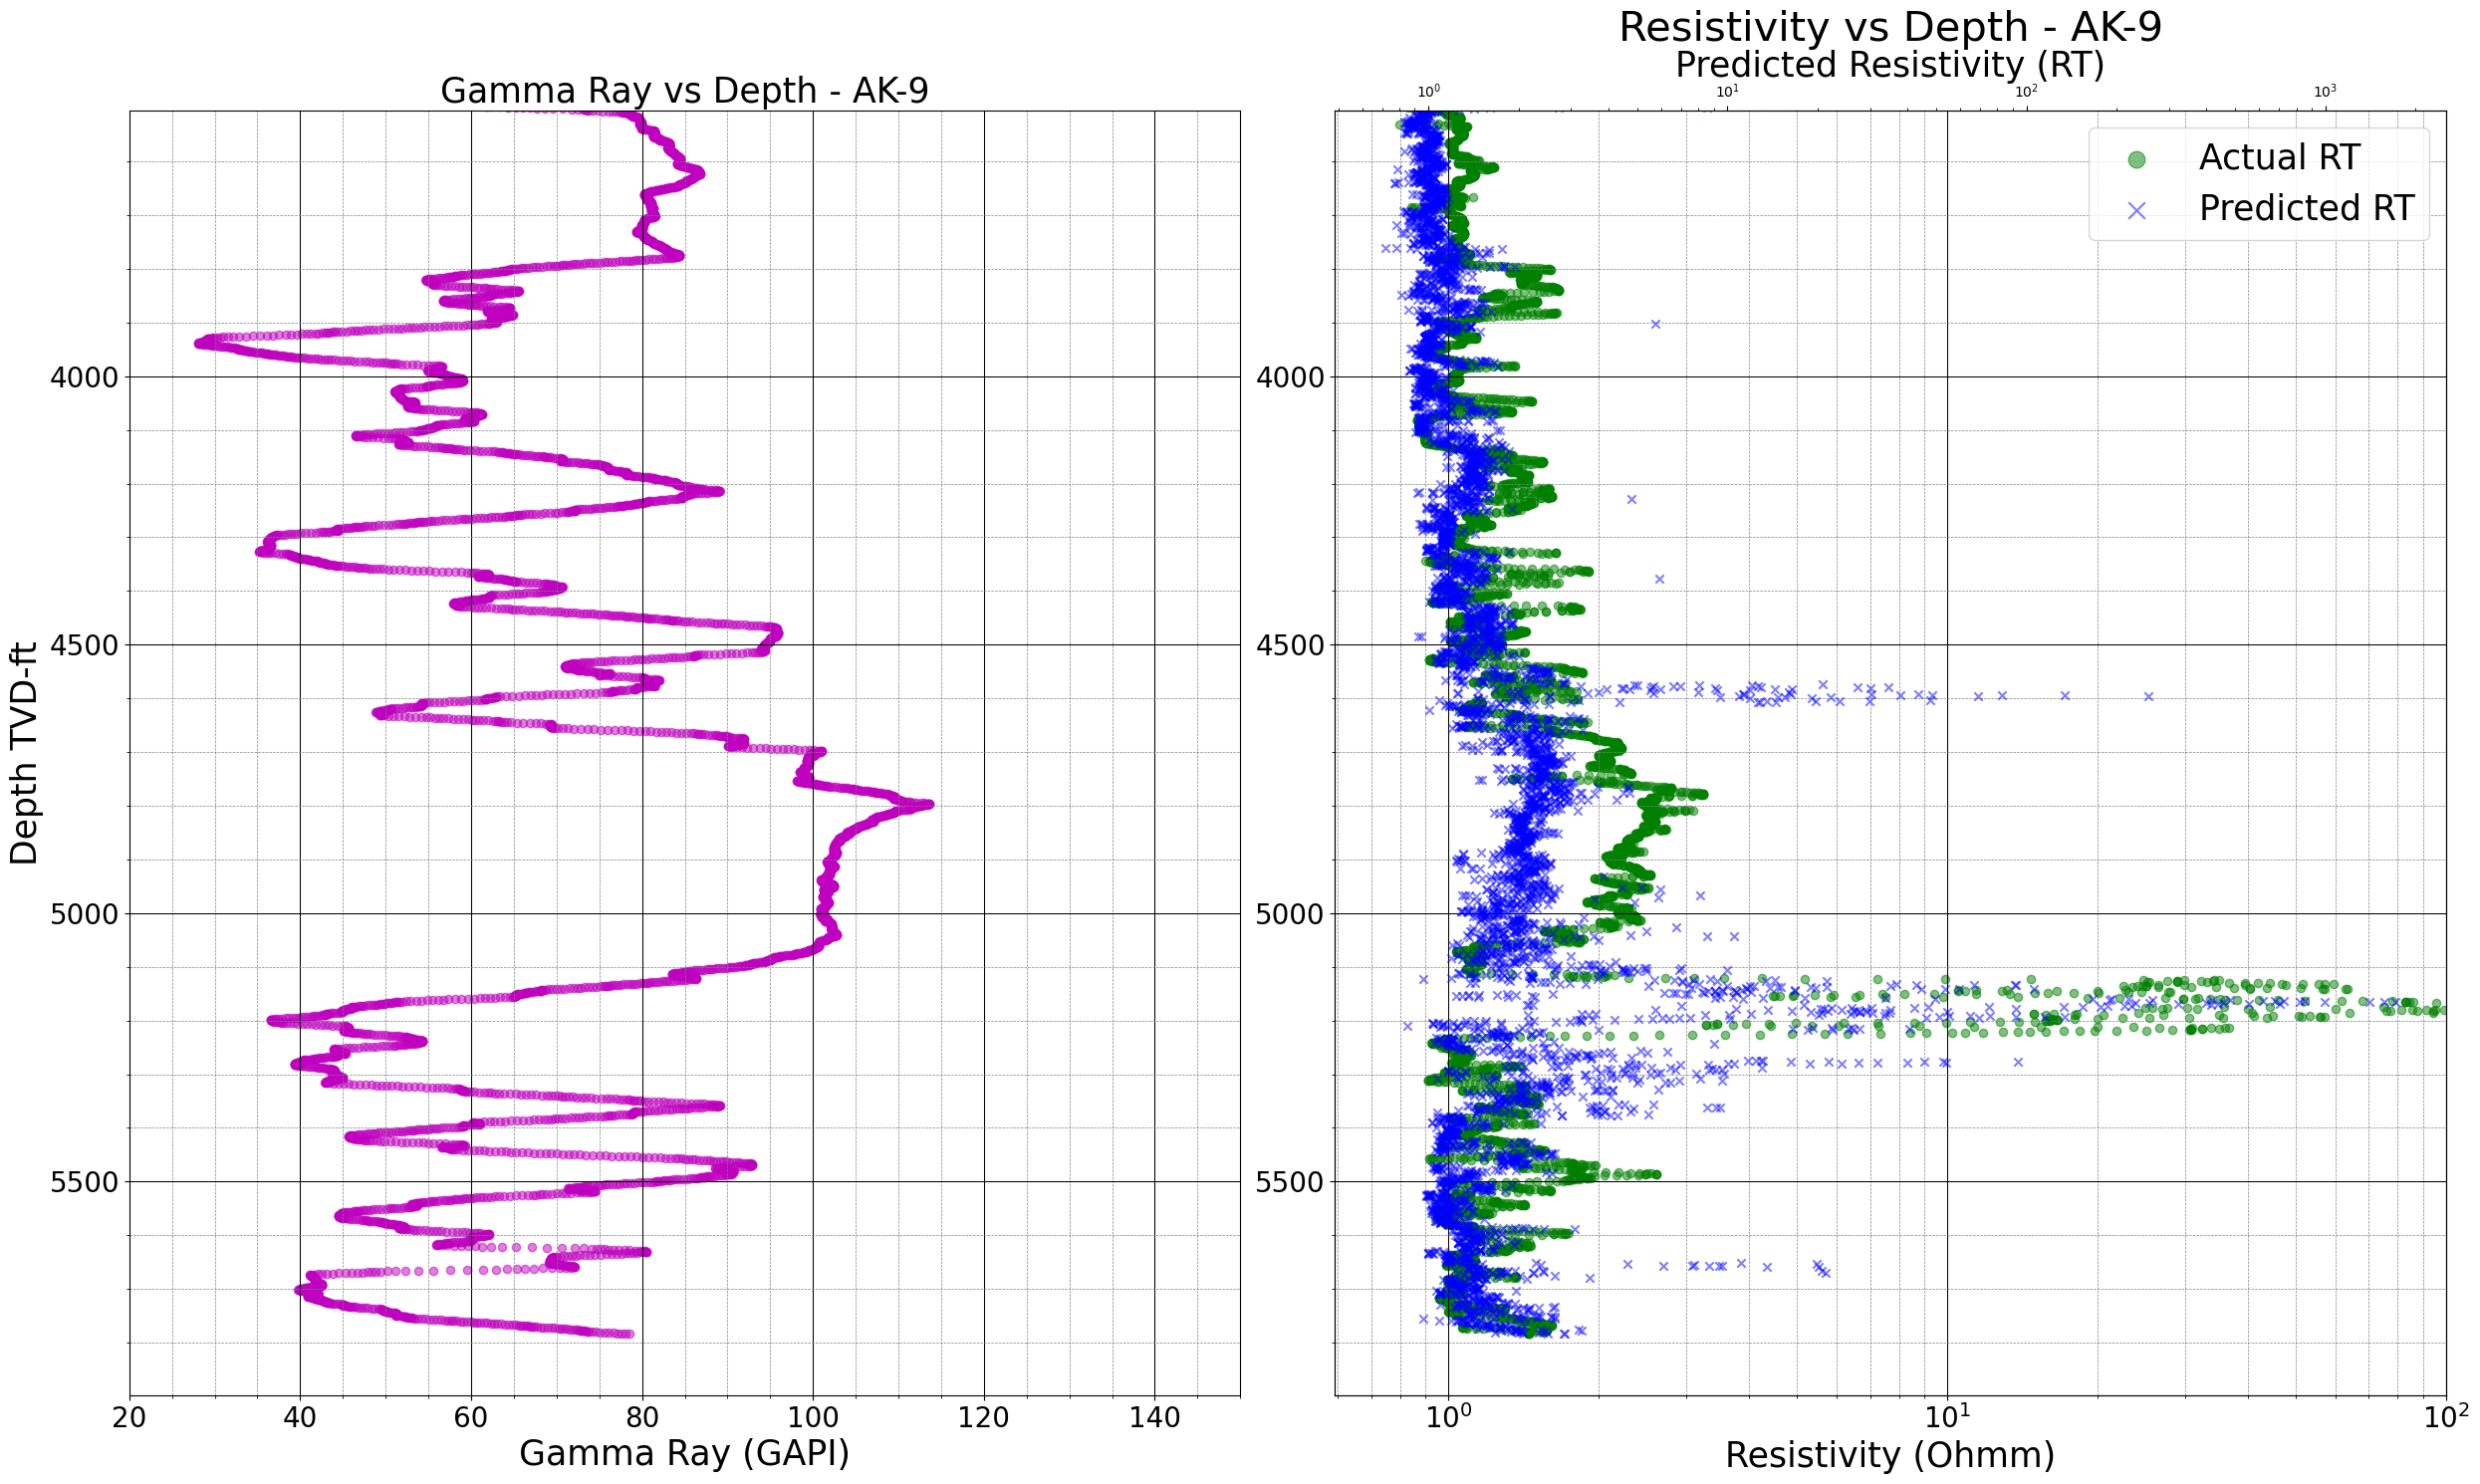

In [17]:
# ------------------------------
# Define ak9_df by reading the CSV file for well "AK-9"
# ------------------------------
ak9_filepath = ROOT / "AK-9.csv"
try:
    ak9_df = pd.read_csv(p(ak9_filepath))
except Exception as e:
    raise RuntimeError(f"Error reading AK-9 CSV file: {e}")

# Check that necessary columns exist in ak6_df.
required_columns = {'DEPT', 'GR', 'RT'}
if not required_columns.issubset(ak9_df.columns):
    raise ValueError(f"AK-9 CSV file must contain the columns: {required_columns}")

# ------------------------------
# Assume that ak9_pred_df has been obtained from predict_RT_random_forest() call.
# If not, you can alternatively predict here using a trained model.
# For demonstration, we assemble ak9_pred_df below:
# We'll assume that the prediction DataFrame must contain "DEPT" and "Predicted_RT". 
# If you already have ak9_pred_df from your previous function call, you can skip this block.
# ------------------------------
## if 'ak9_pred_df' not in globals():
    ## print("ak9_pred_df not found in globals; generating predictions using a dummy RandomForestRegressor...")
    # In case you did not run the prediction, here's a minimal example:
    # (In real usage, run predict_RT_random_forest and assign its output to model, ak9_pred_df, mse.)
    ## from sklearn.ensemble import RandomForestRegressor
    # Prepare test data from ak9_df (using only DEPT and GR, dropping rows with missing values).
    ## ak9_test = ak9_df[['DEPT', 'GR']].dropna().reset_index(drop=True)
    # For demonstration, set up a dummy model and generate random predictions.
    ## dummy_model = RandomForestRegressor()
    ## import numpy as np
    # We create dummy predictions (the same shape as ak9_test rows)
    ## dummy_predictions = np.random.uniform(low=ak9_df['RT'].min(), high=ak9_df['RT'].max(), size=len(ak9_test))
    ## ak9_pred_df = ak9_test.copy()
    ## ak9_pred_df['Predicted_RT'] = dummy_predictions
    
    
# 'smoothen' logs with a rolling mean
#window =100
#for l in list(ak9_df):
    #ak9_df[l] = pd.Series(ak9_df[l].rolling(window=window, min_periods=1).mean())

# 'smoothen' GR in original log only with a rolling mean
window =100
#for l in list(ak9_df):
ak9_df["GR"] = pd.Series(ak9_df["GR"].rolling(window=window, min_periods=1).mean())
    
# 'smoothen' logs with a rolling mean
#window =50
#for l in list(ak9_predictions):
    #ak9_predictions[l] = pd.Series(ak9_predictions[l].rolling(window=window, min_periods=1).mean())

# ------------------------------
# Create the plot.
# ------------------------------
fig, axs = plt.subplots(1, 2, figsize=(25, 15))

# Left subplot: Plot Gamma Ray vs Depth
axs[0].set_title('Gamma Ray vs Depth - AK-9', fontsize=25)
axs[0].scatter(ak9_df['GR'], ak9_df['DEPT'], color='m', alpha=0.5)
axs[0].set_xlabel('Gamma Ray (GAPI)', fontsize=25)
axs[0].set_ylabel('Depth TVD-ft', fontsize=25)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].invert_yaxis()  # Depth increases downward
axs[0].grid(which='minor', color='gray', linestyle='--', linewidth=0.5)
axs[0].grid(which='major', color='black', linestyle='-', linewidth=0.75)
axs[0].minorticks_on()
axs[0].set_xlim(20, 150)
axs[0].set_ylim(bottom=None, top=3505)

# Right subplot: Plot Resistivity vs Depth with twin axes: actual and predicted.
axs[1].set_title('Resistivity vs Depth - AK-9', fontsize=30)
# Plot actual RT (ensure you have valid values in "RT")
actual_scatter = axs[1].scatter(ak9_df['RT'], ak9_df['DEPT'], color='g', alpha=0.5, label='Actual RT')
axs[1].set_xlabel('Resistivity (Ohmm)', fontsize=25)
axs[1].set_xscale('log')  # Using log scale for RT (if applicable)
axs[1].grid(which='minor', color='gray', linestyle='--', linewidth=0.5)
axs[1].grid(which='major', color='black', linestyle='-', linewidth=0.75)
axs[1].minorticks_on()
axs[1].invert_yaxis()  # Depth increases downward

# Create a twin x-axis for predicted RT.
ax_pred = axs[1].twiny()
predicted_scatter = ax_pred.scatter(ak9_predictions['Predicted_RT'], ak9_predictions['DEPT'], 
                                    color='b', marker='x', alpha=0.5, label='Predicted RT')
ax_pred.set_xlabel('Predicted Resistivity (RT)', fontsize=25)
ax_pred.set_xscale('log')
ax_pred.grid(False)   # Disable grid for the twin axis so grid from axs[1] remains clear

axs[1].set_xlim(0,100)
axs[1].set_ylim(bottom=None, top=3505)
axs[1].tick_params(axis='both', which='major', labelsize=20)

# Merge legends from both axes.
handles1, labels1 = axs[1].get_legend_handles_labels()
handles2, labels2 = ax_pred.get_legend_handles_labels()
axs[1].legend(handles1 + handles2, labels1 + labels2, loc='upper right', fontsize=25, markerscale=2)

plt.tight_layout()
plt.show()
